In [2]:
import torch
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# following: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

# Read data
T = 1
path = f"..\\data\\data_T{str(T)}.csv"
names = ['time', 'x1' , 'x2','obs_num']
df = pd.read_csv(path,sep=',', header=0, names=names,index_col=False)
print(df.head())
print(df.shape)

obs = max(df['obs_num'])
print("Number of different trajectory functions",int(obs))



       time        x1        x2  obs_num
0  0.000000  0.000000  0.000000      1.0
1  0.026316  0.016014  0.007989      1.0
2  0.052632  0.032028  0.009184      1.0
3  0.078947  0.048042  0.003586      1.0
4  0.105263  0.064057 -0.008806      1.0
(11400, 4)
Number of different trajectory functions 300


In [3]:
# Train test split

train_data = df[df['time']< (0.7 * T)]
test_data = df[df['time']>= (0.7 * T)]
print("train shape, test shape: ",train_data.shape, test_data.shape)
print(train_data.head())

train_times = df[df['time']< (0.7 * T)]["time"].tolist()
test_times =  df[df['time']>= (0.7 * T)]["time"].tolist()
print("train times: ", train_times)
print("test times: ", test_times)

train shape, test shape:  (8100, 4) (3300, 4)
       time        x1        x2  obs_num
0  0.000000  0.000000  0.000000      1.0
1  0.026316  0.016014  0.007989      1.0
2  0.052632  0.032028  0.009184      1.0
3  0.078947  0.048042  0.003586      1.0
4  0.105263  0.064057 -0.008806      1.0
train times:  [0.0, 0.0263157894736842, 0.0526315789473684, 0.0789473684210526, 0.1052631578947368, 0.131578947368421, 0.1578947368421052, 0.1842105263157894, 0.2105263157894736, 0.2368421052631578, 0.2631578947368421, 0.2894736842105263, 0.3157894736842105, 0.3421052631578947, 0.3684210526315789, 0.3947368421052631, 0.4210526315789473, 0.4473684210526315, 0.4736842105263157, 0.5, 0.5263157894736842, 0.5526315789473684, 0.5789473684210527, 0.6052631578947368, 0.631578947368421, 0.6578947368421052, 0.6842105263157894, 0.0, 0.0263157894736842, 0.0526315789473684, 0.0789473684210526, 0.1052631578947368, 0.131578947368421, 0.1578947368421052, 0.1842105263157894, 0.2105263157894736, 0.2368421052631578, 0

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1)) # StandardScaler() # 

# Scaling dataset
scaled_train = scaler.fit_transform(train_data.to_numpy())
scaled_train = pd.DataFrame(scaled_train, columns=names)
print(scaled_train.shape)
print(scaled_train.head())

scaled_test = scaler.fit_transform(test_data.to_numpy())
scaled_test = pd.DataFrame(scaled_test, columns=names)
print(scaled_test.shape)


(8100, 4)
       time        x1        x2  obs_num
0  0.000000  0.000000  0.918871      0.0
1  0.038462  0.023549  0.922072      0.0
2  0.076923  0.047099  0.922551      0.0
3  0.115385  0.070648  0.920308      0.0
4  0.153846  0.094197  0.915343      0.0
(3300, 4)


In [5]:
# define positional encoding
# def positional_encoding(T, d_model):
#     # Initialize positional encoding matrix
#     t= np.linspace(0, 1, num=T)
#     pe = np.zeros((t.shape[0], d_model))
    
#     # Compute positional encodings
#     for pos, time in enumerate(t):
#         for i in range(d_model):
#             if i % 2 == 0:
#                 pe[pos, i] = np.sin(time / (10000 ** (2 * i / d_model)))
#             else:
#                 pe[pos, i] = np.cos(time / (10000 ** (2 * (i-1) / d_model)))
    
#     return np.array(pe)



# ## Save data
# ID = []
# PE = []
# d_model  = 1
# N = 10

# for i in range(N):
#     PE += [positional_encoding(T-1, d_model)[:,d_model-1]]

# PE = np.array(PE)
# print(PE)
# PE= PE.flatten()
# print(PE.shape)

In [6]:
# PE_train = PE[:training_data_len]
# PE_test  = PE[training_data_len:]

# scaled_train["u"] = scaled_train["u"] + PE_train
# scaled_train["dx_dt"] = scaled_train["dx_dt"] + PE_train

# scaled_test["u"] = scaled_test["u"] + PE_test
# scaled_test["dx_dt"] = scaled_test["dx_dt"] + PE_test

# print(scaled_train.head())
# print(scaled_test.head())

In [17]:
# Create sequences
def to_sequences(seq_size, df, pred_len):
    x = []
    y = []
    times_x = []
    times_y = []
    
    overlap = 1 #seq_size - pred_len
    for obs in df['obs_num'].unique():
        df_obs = df[df['obs_num']==obs]
        obs_x1 = df_obs['x1'].tolist()
        obs_x2 = df_obs['x2'].tolist()
        t = df_obs['time'].tolist()
        for i in range((len(obs_x1))-seq_size-pred_len) : #create input and pred windows based on trajectory function
            
            window1 = obs_x1[i:(i+seq_size)]  # x at time t
            window2 = obs_x2[i:(i+seq_size)]  # u at time t
            t_x = t[i:(i+seq_size)]
        
            after_window1 = obs_x1[i+seq_size-overlap : i+seq_size+pred_len]  # delta x at time t+1 ( x_t+1 - x_t = delta_x_t+1)
            after_window2 = obs_x2[i+seq_size-overlap : i+seq_size+pred_len]
            t_y = t[i+seq_size-overlap : i+seq_size+pred_len]
            
            window = [[x, u] for x,u in zip(window1, window2)]
            after_window = [[x, u] for x,u in zip(after_window1, after_window2)]
            
            x.append(window)
            y.append(after_window)
            
            
            times_x.append(t_x)
            times_y.append(t_y)

    #return np.array(x).transpose((0,2,1)), np.array(y).transpose(0,2,1)
    return np.array(x), np.array(y), np.array(times_x), np.array(times_y)
pred_len = 4
sequence_size = 5

X_train, y_train, X_train_times, y_train_times = to_sequences(sequence_size, scaled_train, pred_len)


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
X_test,  y_test, X_test_times, y_test_times  = to_sequences(sequence_size, scaled_test, pred_len)
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([5400, 5, 2]) torch.Size([5400, 5, 2])
torch.Size([600, 5, 2]) torch.Size([600, 5, 2])


In [18]:
# from torch.utils.data import Dataset, DataLoader
# batch_size = 128
# class TimeSeriesDataset(Dataset):
#     def __init__(self, X, Y):
#         self.X = X
#         self.Y = Y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.Y[idx]

# train_dataset = TimeSeriesDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    ## NB dropout layer is only applied during training not inference (https://keras.io/api/layers/regularization_layers/dropout/)
    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    # x = layers.Dropout(dropout)(x)
    # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation=None)(x)
    
    #x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [20]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.25,
    mlp_dropout=0.25,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    #x = layers.Dense(24)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    #x = layers.GlobalAveragePooling2D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(2, activation=None)(x)
    return keras.Model(inputs, outputs)

In [23]:
# model parameters:
model_params = {
    'input_shape': (sequence_size,2),
    'head_size':2,
    'num_heads': 1,
    'ff_dim': 16, #32
    'num_transformer_blocks': 1,
    'mlp_units': [24], #24
    'mlp_dropout': 0.05,
    'dropout': 0.05,
    'validation_split': 0.2,
    'epochs':3000,
    'batch_size': 128,
    'learning_rate': 1e-3
}

In [24]:
model = build_model(
    input_shape = model_params["input_shape"],
    head_size = model_params["head_size"],
    num_heads = model_params["num_heads"],
    ff_dim = model_params["ff_dim"],
    num_transformer_blocks = model_params['num_transformer_blocks'],
    mlp_units = model_params["mlp_units"],
    mlp_dropout = model_params["mlp_dropout"],
    dropout = model_params["dropout"],
)

model.compile(
    loss="mean_absolute_percentage_error",
    optimizer=keras.optimizers.Adam(learning_rate=model_params['learning_rate'])
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split = model_params["validation_split"],
    epochs = model_params["epochs"],
    batch_size = model_params["batch_size"],
    #callbacks=callbacks,
    shuffle=True,
)
model.evaluate(X_test, y_test) #, verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 2)      │          4 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 2)      │         24 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 5, 2)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 5, 2)      │          0 │ dropout_9[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 2)      │          4 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5, 16)     │         48 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 5, 16)     │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5, 2)      │         34 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 5, 2)      │          0 │ dense_9[0][0],    │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 5, 24)     │         72 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 5, 24)     │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 5, 2)      │         50 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 236 (944.00 B)

 Trainable params: 236 (944.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 152.1213 - val_loss: 91.2593
Epoch 2/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 109.6160 - val_loss: 79.2847
Epoch 3/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 94.9684 - val_loss: 80.5621
Epoch 4/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 85.4400 - val_loss: 72.9703
Epoch 5/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 80.7364 - val_loss: 72.7310
Epoch 6/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 84.9871 - val_loss: 71.7257
Epoch 7/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75.8136 - val_loss: 70.6787
Epoch 8/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74.1685 - val_loss: 68.4314
Epoch 9/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 76.5399 - val_loss: 75.5595
Epoch 10/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 85.0643 - val_loss: 67.9527
Epoch 11/3000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 72.5838 - val_loss: 64.2799
Epoch 12/3000
34/34 ━━━━━━━

10.830774307250977

In [25]:
name = 'TNN_traj_enc_2.keras'
model.save(name , overwrite=True)

In [26]:
output = model.predict(X_test)
print(output)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[[[0.53515506 0.5315547 ]
  [0.54960895 0.4723051 ]
  [0.56388116 0.41077408]
  [0.57820654 0.34856865]
  [0.5924882  0.28493297]]

 [[0.54966605 0.4730748 ]
  [0.56393826 0.41154367]
  [0.5782593  0.34930867]
  [0.5925349  0.28558633]
  [0.6066606  0.21993864]]

 [[0.04761875 0.5039555 ]
  [0.04832595 0.4443835 ]
  [0.04732031 0.3824551 ]
  [0.04679663 0.31818178]
  [0.04936004 0.2537032 ]]

 ...

 [[0.5082768  0.86404574]
  [0.5176682  0.8066474 ]
  [0.526763   0.7465793 ]
  [0.53555727 0.69276065]
  [0.54478365 0.6297194 ]]

 [[0.81956154 0.65873975]
  [0.844545   0.604146  ]
  [0.8693263  0.5469954 ]
  [0.8939462  0.48783833]
  [0.91842926 0.42670774]]

 [[0.84459376 0.60480225]
  [0.8693819  0.54774576]
  [0.8940018  0.48858887]
  [0.91848075 0.42742947]
  [0.9431177  0.36631233]]]


In [27]:
print(y_test.shape)
print(output.shape)


torch.Size([600, 5, 2])
(600, 5, 2)


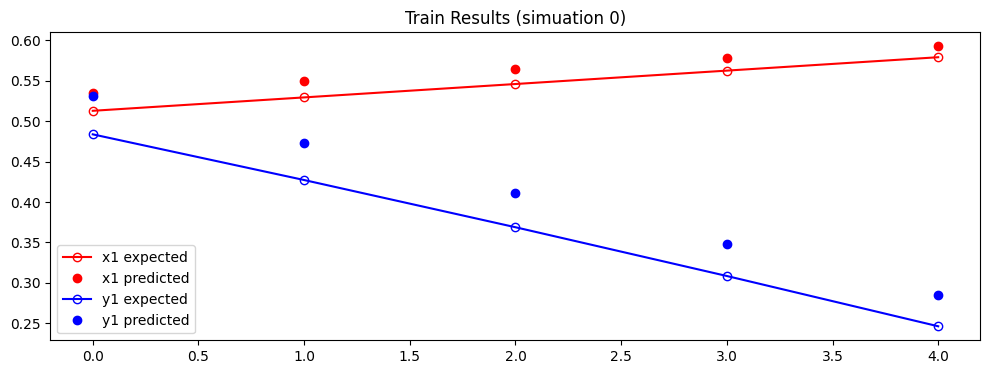

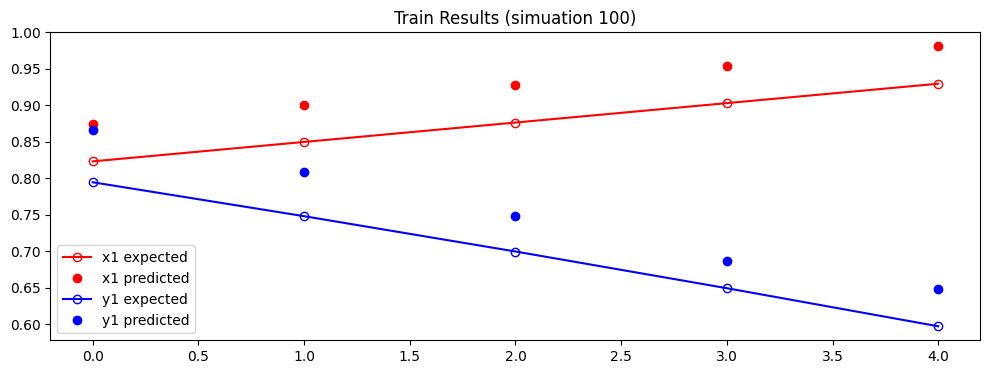

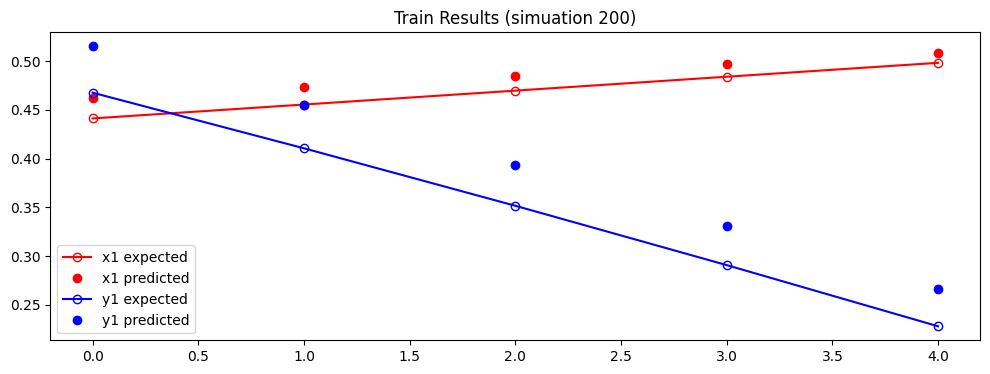

In [28]:
# display train results
import matplotlib.pyplot as plt

colours = ["r", "b", "g", "m", "c", "tab:orange", "tab:brown", "tab:pink", "tab:gray"]
data_files = ["x1", "y1"]
for i in [0, 100, 200]: # select batches
    for d, name in enumerate(data_files):
    
        plt.figure(i, figsize=(12, 4))
        plt.plot( y_test[i,:,d].detach().numpy(), "-o",fillstyle="none", color=colours[d], label=f'{name} expected')
        plt.plot( output[i,:,d] , "o", color=colours[d], label=f'{name} predicted')
        
        plt.title(f"Train Results (simuation {i})")
        plt.legend()

In [29]:

# # Evaluate the model
# model.eval()
# outputs = []
# with torch.no_grad():
#     output = model(X_test, X_test, sequence_size)
#     outputs += output
#     test_loss = criterion(output, y_test)
#     print(f'Test MSE Loss: {test_loss.item():.4f}')

# Evaluate the model
model.eval()
outputs = []
expected = []
avg_loss = 0 
with torch.no_grad():

    for b in range(X_test.shape[0]):   
        tgt = X_test[b, -1,:].unsqueeze(0) #overlap
        for i in range(pred_len+1):
            output = model(X_test[b,:,:], tgt, tgt.shape[0])
            # print(i, X_test.shape ,output.shape)
            tgt = torch.cat([tgt, output[ -1:, :]], dim=0)

        outputs += [output]
        expected += [targets]
        test_loss = criterion(output, y_test[b,:,:])
        avg_loss += test_loss.item()
    #print(f'Test MSE Loss: {test_loss.item():.4f}')

print("Average Loss: ", avg_loss/len(outputs))


AttributeError: 'Functional' object has no attribute 'eval'

In [ ]:
# #save model
model_path = ".\\toy_traj_enc.pt"
torch.save(model.state_dict(), model_path)

In [ ]:
outputs = np.array(outputs)
print(y_test.shape, outputs.shape)
print(y_test_times.shape)

In [ ]:
# display test results
import matplotlib.pyplot as plt
for i in [0, 100, 250]:
    
    plt.figure(i, figsize=(6, 4))
    plt.plot(X_test_times[i,:], X_test[i,:,0], "-o", label='x input')
    plt.plot(y_test_times[i,:], y_test[i,:,0], "-o", label='x expected')
    plt.plot(y_test_times[i,:], outputs[i,:,0] , "x", label='x predicted')
    
    plt.plot(X_test_times[i,:], X_test[i,:,1], "-o", label='y input')
    plt.plot(y_test_times[i,:],y_test[i,:,1], "-o", label='y expected')
    plt.plot(y_test_times[i,:],outputs[i,:,1] , "x", label='y predicted')
    plt.title(f"Test Results TST on unseen data")
    plt.legend()

In [ ]:
from torchinfo import summary

print(summary(model, input_data=(X_test, X_test, sequence_size)))

In [ ]:
print("Transformer layers in order of connection:")
for name, layer in model.named_children():
    print(f"{name}: {layer}")

In [ ]:
print("All submodules in the transformer:")
for name, module in model.named_modules():
    print(f"{name}: {module}")